In [1]:
#loading libraries
library(psych)
library(reshape)
library(dplyr)
library(RColorBrewer)
library(gridExtra)
library(ggplot2)
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myClustering.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myBasic.R")

#loading data
dados <-read.csv("event.csv", header = TRUE, sep = ",")
head(dados)
nrow(dados)
ncol(dados)

Warning message:
"package 'reshape' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following object is masked from 'package:reshape':

    rename

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha



id,session,type,agent,time,attr1,attr2,attr3
21898,194,plantar,grama,3,252,225,325
21899,194,plantar,grama,5,254,275,327
21900,194,plantar,grama,7,256,325,326
21901,194,desenvolvimento,grama,10,257,225,325
21902,194,plantar,grama,9,258,375,326
21903,194,desenvolvimento,grama,12,259,275,327


[1] 315401

[1] 8

In [2]:
dados$id <- NULL #removing the id column

summary(dados)

#Turning categorical attributes into factors
cols = c("type", "agent")
fac.dados = dados
fac.dados[cols] = lapply(dados[cols], factor)
summary(fac.dados)


    session                        type               agent       
 Min.   :194   ColisÃ£o sem resultado:213491   tomate    : 33447  
 1st Qu.:276   plantar               : 19487   besouro   : 30828  
 Median :290   desenvolvimento       : 18330   pulgao    : 29153  
 Mean   :302   Novo inseto           : 17707   cigarrinha: 23419  
 3rd Qu.:330   colher                : 16785   joaninha  : 16770  
 Max.   :444   Predacao              : 10280   grilo     : 15633  
               (Other)               : 19321   (Other)   :166151  
      time          attr1          attr2          attr3          
 Min.   :   1   Min.   :   0   Min.   :  -1   Min.   :-24999623  
 1st Qu.: 332   1st Qu.: 575   1st Qu.: 275   1st Qu.:      175  
 Median : 754   Median :1134   Median : 525   Median :      326  
 Mean   :1017   Mean   :1857   Mean   : 668   Mean   :  1384749  
 3rd Qu.:1739   3rd Qu.:2503   3rd Qu.: 754   3rd Qu.:  2070287  
 Max.   :2759   Max.   :7152   Max.   :7150   Max.   :  8300311  
  

    session                        type               agent       
 Min.   :194   ColisÃ£o sem resultado:213491   tomate    : 33447  
 1st Qu.:276   plantar               : 19487   besouro   : 30828  
 Median :290   desenvolvimento       : 18330   pulgao    : 29153  
 Mean   :302   Novo inseto           : 17707   cigarrinha: 23419  
 3rd Qu.:330   colher                : 16785   joaninha  : 16770  
 Max.   :444   Predacao              : 10280   grilo     : 15633  
               (Other)               : 19321   (Other)   :166151  
      time          attr1          attr2          attr3          
 Min.   :   1   Min.   :   0   Min.   :  -1   Min.   :-24999623  
 1st Qu.: 332   1st Qu.: 575   1st Qu.: 275   1st Qu.:      175  
 Median : 754   Median :1134   Median : 525   Median :      326  
 Mean   :1017   Mean   :1857   Mean   : 668   Mean   :  1384749  
 3rd Qu.:1739   3rd Qu.:2503   3rd Qu.: 754   3rd Qu.:  2070287  
 Max.   :2759   Max.   :7152   Max.   :7150   Max.   :  8300311  
  

In [3]:
#filtering not currently needed attributes and event types

#plants
pop.plant = fac.dados[c(1,2,3,4)] %>% filter((type=="plantar"|type=="Predacao"|type=="colher") & (agent=="tomate"|agent=="tomate em desenvolvimento"|agent=="milho"|agent=="milho em desenvolvimento"|agent=="couve"|agent=="couve em desenvolvimento"|agent=="grama"|agent=="grama em desenvolvimento"))
pop.plant = pop.plant[order(pop.plant$session, pop.plant$time),]

#pests  
pop.plague = fac.dados[c(1,2,3,4)] %>% filter((type=="morte"|type=="Predacao"|type=="Novo inseto") & (agent=="grilo"|agent=="lagarta"|agent=="pulgao"|agent=="cigarrinha"))
pop.plague = pop.plague[order(pop.plague$session, pop.plague$time),]

#predators
pop.predator = fac.dados[c(1,2,3,4)] %>% filter((type=="morte"|type=="Novo inseto"|type=="remover predador") & (agent=="besouro"|agent=="joaninha"))
pop.predator = pop.predator[order(pop.predator$session, pop.predator$time),]

gap = 10


In [4]:
#function to create dataframe
create_dataframe <- function(columm, gap) {
  df <- data.frame(matrix(ncol = columm, nrow = 0))
  n <- seq(1,columm,1)
  n[1] = 'session'
  for (i in 2:columm) {
    n[i] = paste('time',gap*(i-1))
  }
  names(df) = n
  return(df)
}

#function to fill NA values
fill_na <- function(data, rows, datapop) {
  for (i in 1:rows) {
    start = FALSE
    end = datapop %>% filter(session == data[i,1])
    end <- ceiling(max(end$time)/gap+1)
    for (j in 2:length(data)){
      if (j <= end){
        if (is.na(data[i,j])){
          if (start){
            data[i,j] <- data[i, j-1]
          }else{
            data[i,j] <- 0
          }
        }else{
          start = TRUE
        }
      }else{
        data[i,j] <- 0
      }
    }
  }
  return(data)
}


In [5]:
#creating plant population series
num_col = floor(max(pop.plant$time)/gap) + 2
series.pop.plant <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_plant = 0
for(i in 1:length(pop.plant$session)){
    session <- pop.plant[i,]$session
    if(session != actual_session){
      line = line + 1
      actual_session <- session
      total_plant = 0
      series.pop.plant[line, 1] <- actual_session
    }
    if(pop.plant[i,]$type == "plantar"){
      total_plant = total_plant + 1
    }
    if(pop.plant[i,]$type == "Predacao" || pop.plant[i,]$type == "colher"){
      total_plant = total_plant - 1
    }
    col = floor(pop.plant[i,]$time/gap)+2
    if(total_plant < 0) total_plant = 0
    series.pop.plant[line, col] <- total_plant
}
series.pop.plant <- fill_na(series.pop.plant, nrow(series.pop.plant), pop.plant)
#series.pop.plant

#creating pest population series
num_col = floor(max(pop.plague$time)/gap) + 2
series.pop.plague <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_plague = 0
for(i in 1:length(pop.plague$session)){
  session <- pop.plague[i,]$session
  if(session != actual_session){
    line = line + 1
    actual_session <- session
    total_plague = 0
    series.pop.plague[line, 1] <- actual_session
  }
  if(pop.plague[i,]$type == "Novo inseto"){
    total_plague = total_plague + 1
  }
  if(pop.plague[i,]$type == "Predacao" || pop.plague[i,]$type == "morte"){
    total_plague = total_plague - 1
  }
  col = floor(pop.plague[i,]$time/gap)+2
  series.pop.plague[line, col] <- total_plague
}
series.pop.plague <- fill_na(series.pop.plague, nrow(series.pop.plague), pop.plague)

#creating predator population series
num_col = floor(max(pop.predator$time)/gap) + 2
series.pop.predator <- create_dataframe(num_col, gap)
actual_session = 0
line = 0
total_predator = 0
for(i in 1:length(pop.predator$session)){
  session <- pop.predator[i,]$session
  if(session != actual_session){
    line = line + 1
    actual_session <- session
    total_predator = 0
    series.pop.predator[line, 1] <- actual_session
  }
  if(pop.predator[i,]$type == "Novo inseto"){
    total_predator = total_predator + 1
  }
  if(pop.predator[i,]$type == "morte" || pop.predator[i,]$type == "remover predador"){
    total_predator = total_predator - 1
  }
  col = floor(pop.predator[i,]$time/gap)+2
  if(total_predator < 0) total_predator = 0
  series.pop.predator[line, col] <- total_predator
}
series.pop.predator <- fill_na(series.pop.predator, nrow(series.pop.predator), pop.predator)


In [6]:
#function that combines the series and performs the clustering
return_cluster_comb <- function(data_serie1, data_serie2, data_serie3, sessions, num_k, cols) {
  series1 <- data_serie1[,1:cols] %>% filter(session %in% sessions)
  series2 <- data_serie2[,1:cols] %>% filter(session %in% sessions)
  series3 <- data_serie3[,1:cols] %>% filter(session %in% sessions)
  series.pop.comb <- merge(series1, series2, by.x = "session", by.y = "session")
  series.pop.comb <- merge(series.pop.comb, series3, by.x = "session", by.y = "session")
  series.pop.comb$k <- fit.cluster_kmeans(cluster_kmeans(k=num_k), series.pop.comb[,2:length((series.pop.comb))])
  return(series.pop.comb)
}

In [7]:
###Creating graphs of aggregated series ########

#function for line plots
line_cluster_sep <- function(data_serie, gap, title1, title2, title3, linf1, lsup1, linf2, lsup2, linf3, lsup3) {
  #separating the series
  serie1 <- data_serie[,2:61]
  serie1$k <- data_serie$k
  serie2 <- data_serie[,62:121]
  serie2$k <- data_serie$k
  serie3 <- data_serie[,122:181]
  serie3$k <- data_serie$k
  
  #calculating the averages
  mean.serie1 <- as.data.frame(serie1 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  mean.serie2 <- as.data.frame(serie2 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  mean.serie3 <- as.data.frame(serie3 %>% group_by(k)%>% summarise(across(everything(), list(mean))))
  
  #data plot 1
  data_plot1 <- melt(mean.serie1, id.vars = c(1))
  data_plot1 <- data_plot1[order(data_plot1$k, data_plot1$variable),]
  #creating x axis
  data_plot1$x <- seq(from = 10, to = 600, by = gap)
  
  #data plot 2
  data_plot2 <- melt(mean.serie2, id.vars = c(1))
  data_plot2 <- data_plot2[order(data_plot2$k, data_plot2$variable),]
  #creating x axis
  data_plot2$x <- seq(from = 10, to = 600, by = gap)
  
  #data plot 3
  data_plot3 <- melt(mean.serie3, id.vars = c(1))
  data_plot3 <- data_plot3[order(data_plot3$k, data_plot3$variable),]
  #creating x axis
  data_plot3$x <- seq(from = 10, to = 600, by = gap)
  
  #plot
  p1 <- ggplot(data_plot1, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  2, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  6, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title1)
    labs(title=title1,x ="Time", y = "Quantity", color = "K")+
    scale_y_continuous(limits = c(linf1, lsup1))+#, breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
        axis.line = element_line(size = 2, colour = "grey80"),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        legend.text = element_text(size=14))
        #legend.position = "bottom")
  
  p2 <- ggplot(data_plot2, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  5, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  10, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title2)
    labs(title=title2,x ="Time", y = "Quantity", color = "K")+
    scale_y_continuous(limits = c(linf2, lsup2))+#, breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          axis.line = element_line(size = 2, colour = "grey80"),
          axis.ticks.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.text = element_text(size=14))
  
  
  p3 <- ggplot(data_plot3, aes(x=x, y=value, group=k)) +
    geom_hline(yintercept =  5, linetype="dashed", color = "grey80", size=.7) + 
    geom_hline(yintercept =  10, linetype="dashed", color = "grey80", size=.7) +
    scale_color_brewer(palette="Dark2")+
    geom_line(aes(color=as.factor(k)), size = 1.25) +
    #ggtitle(title3)
    labs(title=title3,x ="Time", y = "Quantity", color = "K")+
    scale_y_continuous(limits = c(linf3, lsup3))+#, breaks = c(15,30), labels = c("20", "40")) +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          axis.line = element_line(size = 2, colour = "grey80"),
          axis.ticks.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.text = element_text(size=14))
  
  g = grid.arrange(p1, p2, p3, nrow=3)
  return(g)
}


## Group 2 and 4 sessions
sessions <- c(211,212,239,240,241,259,260,261,262,263,264,271,272,273,274,275,300,303,305,306,307,308,309,328,330,331,332,333,334,335,336,337,338,339,340,341,342,344
              ,345,350,351,352,356,357,373,374,375,381,382,383,384,385,402,403,407,414,416,429)

sessions_abv5_or_gameover = fac.dados %>% filter ((session %in% sessions)&((time > 300)|(type=="game over")))

summary(sessions_abv5_or_gameover) 
distinct(sessions_abv5_or_gameover %>% select (session))


    session                          type              agent      
 Min.   :211.0   ColisÃ£o sem resultado:55859   cigarrinha:15685  
 1st Qu.:274.0   plantar               : 5111   pulgao    :11269  
 Median :309.0   Novo inseto           : 4874   besouro   : 7749  
 Mean   :315.6   desenvolvimento       : 4775   tomate    : 7565  
 3rd Qu.:340.0   colher                : 4427   joaninha  : 5478  
 Max.   :429.0   Predacao              : 2831   grilo     : 4671  
                 (Other)               : 5609   (Other)   :31069  
      time            attr1          attr2            attr3          
 Min.   :  53.0   Min.   :   0   Min.   :  -1.0   Min.   :-24999623  
 1st Qu.: 562.0   1st Qu.: 833   1st Qu.: 325.0   1st Qu.:      226  
 Median : 834.0   Median :1185   Median : 688.0   Median :      377  
 Mean   : 977.5   Mean   :1338   Mean   : 841.4   Mean   :  2138694  
 3rd Qu.:1217.0   3rd Qu.:1683   3rd Qu.:1267.0   3rd Qu.:  4410263  
 Max.   :2708.0   Max.   :4253   Max.   :424

session
211
212
239
241
240
260
261
259
262
264


Loading required package: cluster


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.6035  0.0000  6.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.5141  0.0000  6.6200 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.72    0.00    6.00 

var,n
1,18
2,6
3,14
4,13


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

session,k
211,3
212,4
239,1
240,3
241,3
259,1
260,3
261,3
262,3
264,4


var,n
1,14
2,19
3,18


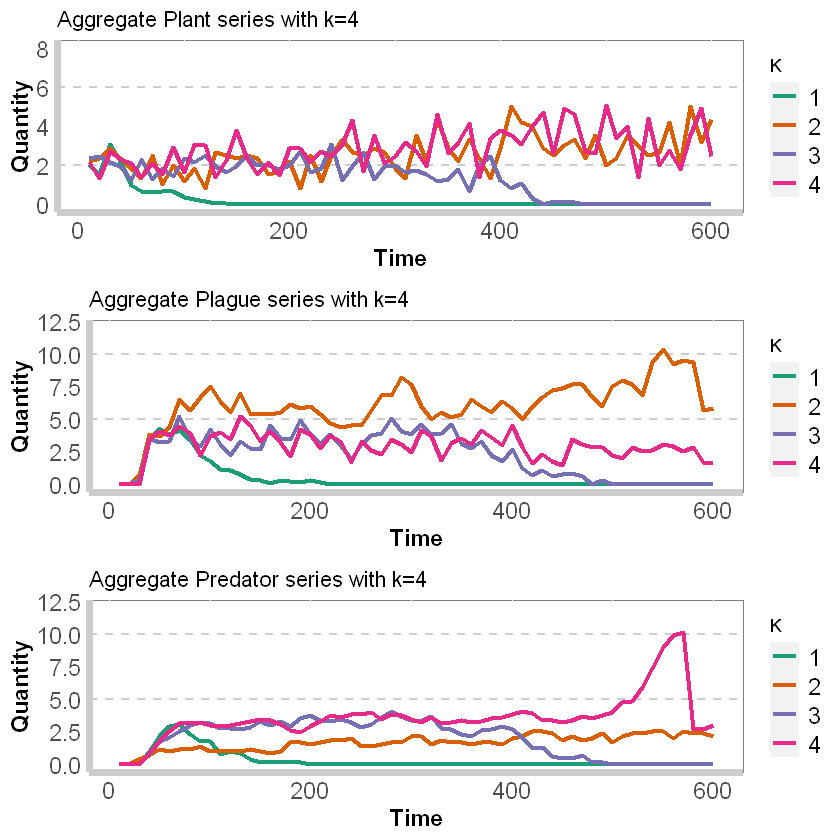

TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

session,k
211,1
212,2
239,3
240,1
241,1
259,3
260,1
261,1
262,1
264,2


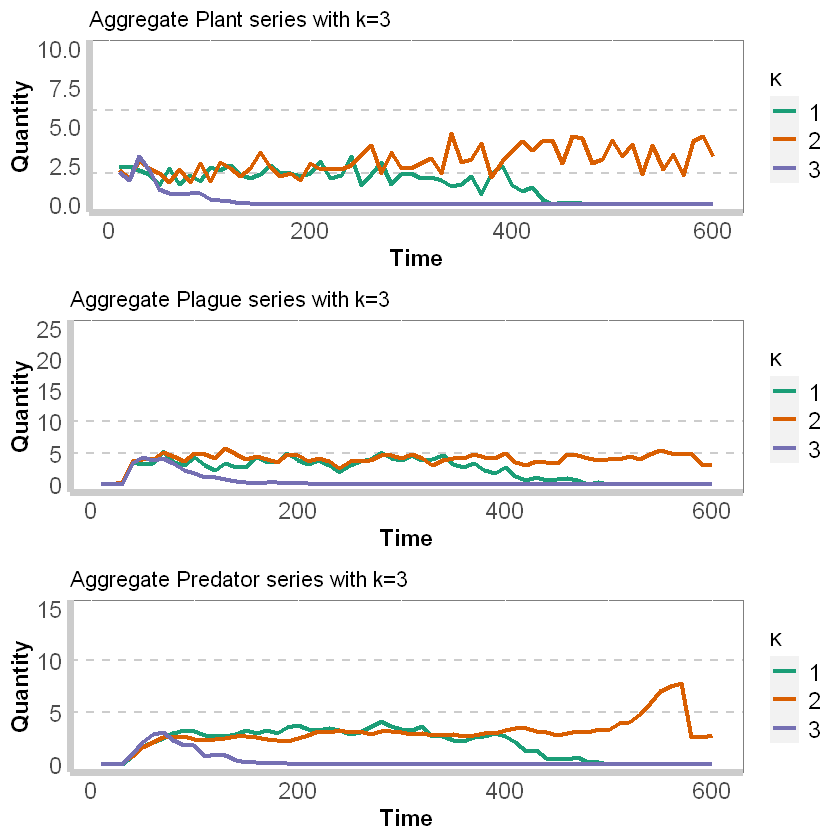

In [8]:
########### Only sessions above 5 minutes and sessions 5 minutes less with game over ##############################
sessions <- c(211,212,239,241,240,260,261,259,262,264,271,272,273,274,275,300,303,305,306,307,308,309,328,330,331,332,333,335,336,338,339,340,337,341,344,345,350,351,352,356,357,374,381,383,384,385,402,403,407,414,416,429)

data_serie <- return_cluster_comb(series.pop.plant, series.pop.plague, series.pop.predator, sessions, 3, 61)

###Winsorizing the series to remove outliers 2%
wseries.pop.plant <- series.pop.plant
wseries.pop.plant[,2:length(wseries.pop.plant)] <- psych::winsor(wseries.pop.plant[,2:length(wseries.pop.plant)], trim = 0.02)
summary(wseries.pop.plant$`time 600`)

wseries.pop.plague <- series.pop.plague
wseries.pop.plague[,2:length(wseries.pop.plague)] <- psych::winsor(wseries.pop.plague[,2:length(wseries.pop.plague)], trim = 0.02)
summary(wseries.pop.plague$`time 600`)

wseries.pop.predator <- series.pop.predator
wseries.pop.predator[,2:length(wseries.pop.predator)] <- psych::winsor(wseries.pop.predator[,2:length(wseries.pop.predator)], trim = 0.02)
summary(wseries.pop.predator$`time 600`)

#####APPLYING Z-SCORE
zscore_plant = wseries.pop.plant
zscore_plant[,2:length(zscore_plant)] = scale(zscore_plant[,2:length(zscore_plant)])
zscore_plant[is.na(zscore_plant)] <- 0

zscore_plague = wseries.pop.plague
zscore_plague[,2:length(zscore_plague)] = scale(zscore_plague[,2:length(zscore_plague)])
zscore_plague[is.na(zscore_plague)] <- 0

zscore_predator = wseries.pop.predator
zscore_predator[,2:length(zscore_predator)] = scale(zscore_predator[,2:length(zscore_predator)])
zscore_predator[is.na(zscore_predator)] <- 0


set.seed(222)

#####CLUSTERING WITH K=4
zdata_serie <- return_cluster_comb(zscore_plant, zscore_plague, zscore_predator, sessions, 4, 61)
count(zdata_serie, var = k)
data_serie$k <- zdata_serie$k
line_cluster_sep(data_serie, 10, "Aggregate Plant series with k=4", "Aggregate Plague series with k=4", "Aggregate Predator series with k=4",0,8,0,12,0,12)
data_serie %>% select(session, k)

k4_classification <- zdata_serie$k

######CLUSTERING WITH K=3
set.seed(223)
zdata_serie <- return_cluster_comb(zscore_plant, zscore_plague, zscore_predator, sessions, 3, 61)
count(zdata_serie, var = k)
data_serie$k <- zdata_serie$k
line_cluster_sep(data_serie, 10, "Aggregate Plant series with k=3", "Aggregate Plague series with k=3", "Aggregate Predator series with k=3",0,10,0,25,0,15)
data_serie %>% select(session, k)

k3_classification <- zdata_serie$k


In [9]:
### importing sessions data

session_data <-read.csv2("session_data.csv", header = TRUE, sep = ";")
head(session_data)
nrow(session_data)
ncol(session_data)

session_data <- session_data %>% filter(session %in% sessions)
session_data$k <- k4_classification
#session_data$k <- k3_classification
nrow(session_data)
summary(session_data)

teste <- as.data.frame(session_data[,c(2,4,21)])
#teste
teste <- teste %>% filter(conhecimento_previo != "AG") %>% filter(conhecimento_previo != "OF") 
#n <- count(teste, var = grupo)
#teste$n <- n$n
#colnames(teste) <- c("k", "group", "conhecimento")
teste

ï..key,grupo,session,k,pontuacao,tempo,plantacao,colheita,predadores_inseridos,predadores_removidos,...,metas_lancadas,metas_cumpridas,pontuacao.tempo,colheita.plantacao,meta_cumprida.lancada,respQ10,pontosQ10,respostasQ11,pontosQ11,conhecimento_previo
3342ed9e,2,211,4,2700,430,53,48,14,3,...,0,0,6.3,0.91,0.00,"1,3",0.8,AGCB,1,AG
3342ed9e,2,212,3,11385,1709,383,310,64,76,...,9,5,6.7,0.81,0.56,"1,3",0.8,AGCB,1,AG
8470df53,2,239,1,360,96,10,10,5,3,...,0,0,3.8,1.00,0.00,3,0.6,ND,0,OF
8470df53,2,240,4,380,414,41,38,16,2,...,0,0,0.9,0.93,0.00,3,0.6,ND,0,OF
8470df53,2,241,4,2430,429,56,51,18,4,...,2,1,5.7,0.91,0.50,3,0.6,ND,0,OF
14eaca5b,4,259,1,150,53,5,5,5,1,...,0,0,2.8,1.00,0.00,"1,3",0.8,ND,0,AG


[1] 57

[1] 21

[1] 51

      ï..key       grupo          session            k           pontuacao     
 09705fc7: 4   Min.   :2.000   Min.   :211.0   Min.   :1.000   Min.   :     5  
 1f15b27b: 4   1st Qu.:2.000   1st Qu.:273.5   1st Qu.:1.000   1st Qu.:   145  
 c5ed7019: 4   Median :2.000   Median :332.0   Median :3.000   Median :   400  
 42db7020: 3   Mean   :2.863   Mean   :321.4   Mean   :2.431   Mean   :  6592  
 48bcbde1: 3   3rd Qu.:4.000   3rd Qu.:351.5   3rd Qu.:3.500   3rd Qu.:  2772  
 8470df53: 3   Max.   :4.000   Max.   :429.0   Max.   :4.000   Max.   :120645  
 (Other) :30                                                                   
     tempo          plantacao         colheita      predadores_inseridos
 Min.   :  53.0   Min.   :   2.0   Min.   :   1.0   Min.   :  0.00      
 1st Qu.: 102.0   1st Qu.:  12.0   1st Qu.:  10.0   1st Qu.:  5.00      
 Median : 407.0   Median :  45.0   Median :  40.0   Median : 14.00      
 Mean   : 584.4   Mean   : 136.8   Mean   : 117.3   Mean   : 22.53  

grupo,k,conhecimento_previo
2,4,CB
4,1,CB
4,4,CB
4,1,CB
4,2,CB
2,3,AGCB
4,1,AGCB
2,1,CB
2,4,CB


In [10]:
game_stats <- as.data.frame(session_data[,4:16])
game_stats <- game_stats %>% group_by(k)%>% summarise(across(everything(), list(mean)))
game_stats

k,pontuacao_1,tempo_1,plantacao_1,colheita_1,predadores_inseridos_1,predadores_removidos_1,multas_1,metas_lancadas_1,metas_cumpridas_1,pontuacao.tempo_1,colheita.plantacao_1,meta_cumprida.lancada_1
1,253.3333,98.72222,10.61111,8.00000,4.444444,1.222222,0.7777778,0.500000,0.05555556,2.644444,0.7855556,0.02777778
2,8277.5000,1054.66667,264.33333,206.50000,31.000000,23.500000,2.8333333,3.333333,1.83333333,5.600000,0.6683333,0.35166667
3,3037.1429,403.57143,66.64286,58.92857,15.714286,9.857143,3.5000000,1.428571,0.78571429,7.200000,0.8892857,0.31785714
4,18418.0769,1234.69231,328.15385,290.38462,51.000000,38.153846,14.3076923,4.230769,3.07692308,11.076923,0.8661538,0.45153846


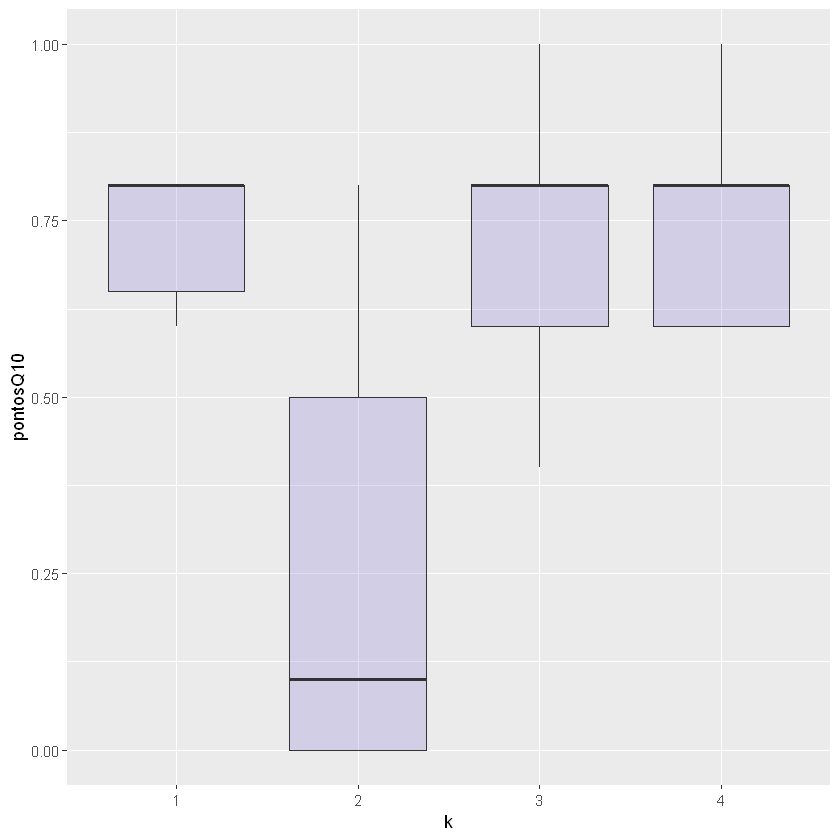

k,Q10_mean,Q10_sd,Q11_mean,Q11_sd,n
1,0.7444444,0.09217772,0.3611111,0.4791400,18
2,0.2666667,0.35023801,0.2500000,0.4183300,6
3,0.7000000,0.17097008,0.5357143,0.4986245,14
4,0.7538462,0.14500221,0.4615385,0.4311582,13


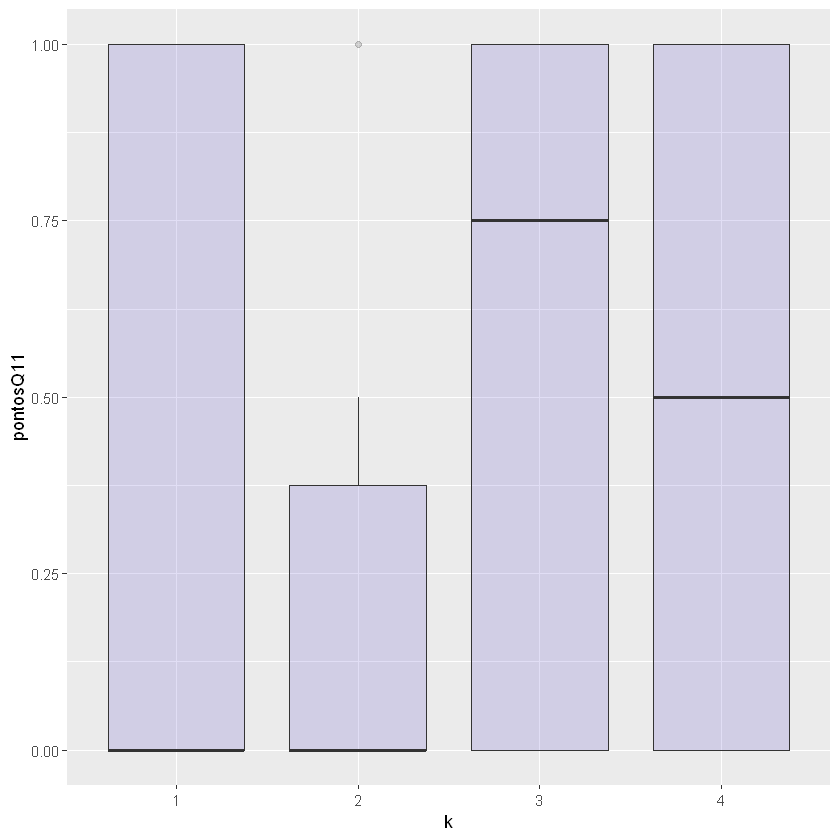

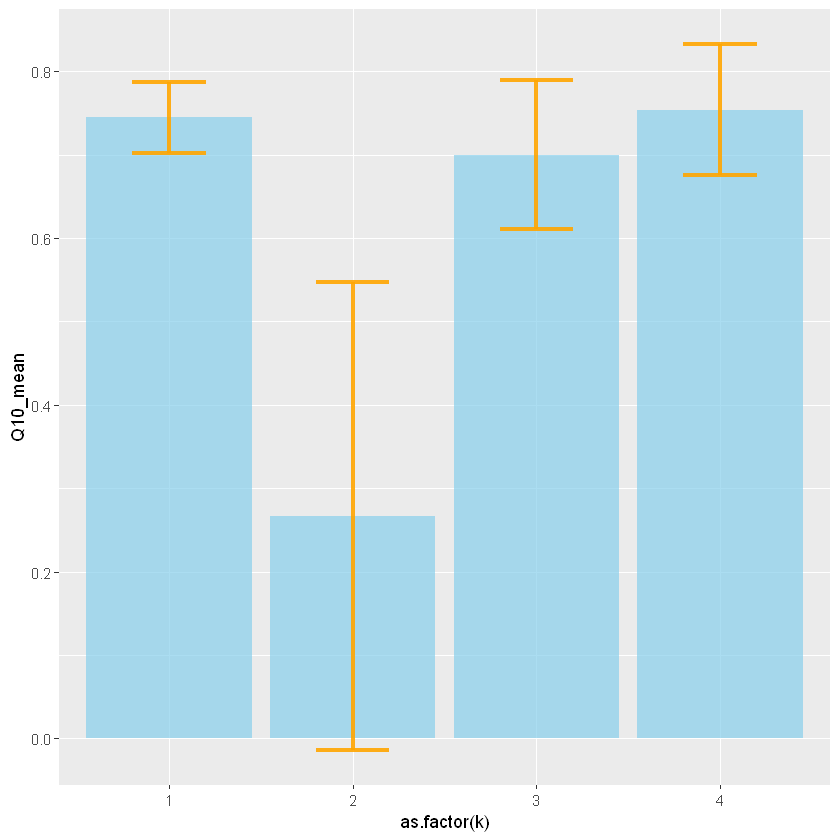

`summarise()` has grouped output by 'k'. You can override using the `.groups` argument.


k,group,Q10_mean,Q10_sd,Q11_mean,Q11_sd,NA
1,2,0.7500000,0.09045340,0.5416667,0.4981025,12
1,4,0.7333333,0.10327956,0.0000000,0.0000000,6
2,2,0.2000000,NA,0.5000000,NA,1
2,4,0.2800000,0.38987177,0.2000000,0.4472136,5
3,2,0.6666667,0.20000000,0.5000000,0.5000000,9
3,4,0.7600000,0.08944272,0.6000000,0.5477226,5
4,2,0.7428571,0.09759001,0.7142857,0.3933979,7
4,4,0.7666667,0.19663842,0.1666667,0.2581989,6


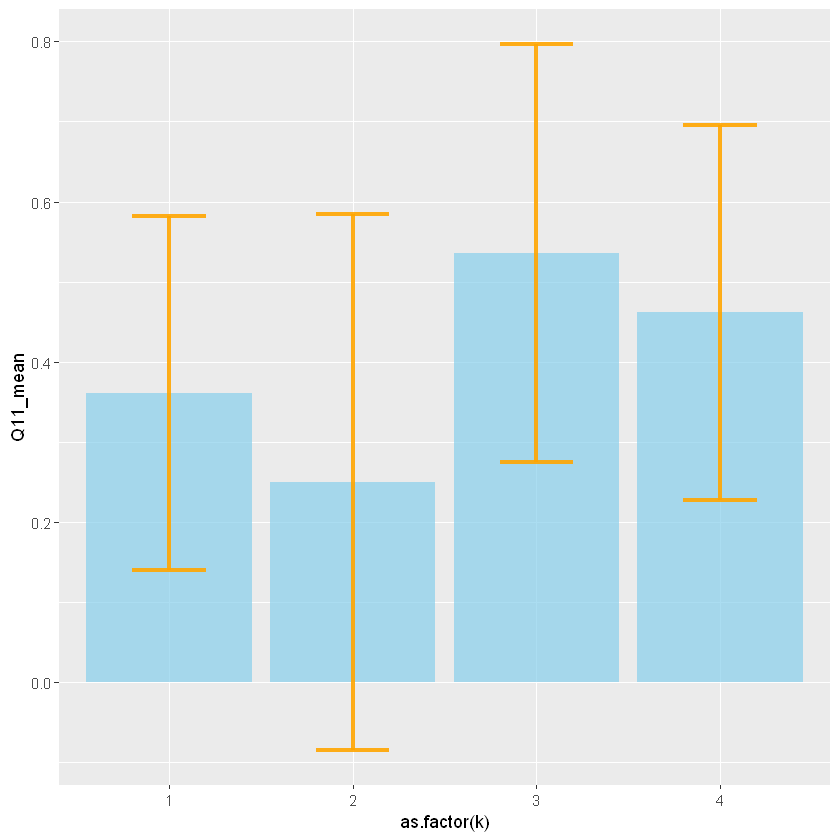

In [11]:
aval_stats <- as.data.frame(session_data[,c(2,4,18,20)])
aval_stats[c(1,2)] = lapply(aval_stats[c(1,2)], factor)

ggplot(aval_stats, aes(x=as.factor(k), y=pontosQ10, fill=grupo)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("k")

ggplot(aval_stats, aes(x=as.factor(k), y=pontosQ11, fill=grupo)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("k")


#ggplot(aval_stats, aes(x=as.factor(k), y=pontosQ10, fill=grupo)) + 
#    geom_boxplot() +
#    facet_wrap(~grupo)

#aval_stats <- aval_stats %>% group_by(k,grupo)
#ggplot(aval_stats, aes(x=as.factor(k), y=pontosQ10, fill=grupo)) + 
#    geom_boxplot()

aval_stats_k <- aval_stats[,c(2,3,4)]
n <- count(aval_stats_k, var = k)
aval_stats_k <- aval_stats_k %>% group_by(k) %>% summarise(across(everything(), list(mean,sd)))
aval_stats_k$n <- n$n
colnames(aval_stats_k) <- c("k", "Q10_mean", "Q10_sd", "Q11_mean", "Q11_sd", "n")
aval_stats_k

#intervalo de confianca 95% -> 1.96 * sd / sqr(n) 
#80%	1.28
#90%	1.645
#95%	1.96
#98%	2.33
#99%	2.58
               
ggplot(aval_stats_k) +
geom_bar( aes(x=as.factor(k), y=Q10_mean), stat="identity", fill="skyblue", alpha=0.7) +
    geom_errorbar( aes(x=as.factor(k), ymin=Q10_mean-(1.96*Q10_sd/sqrt(n)), ymax=Q10_mean+(1.96*Q10_sd/sqrt(n))), width=0.4, colour="orange", alpha=0.9, size=1.3)

ggplot(aval_stats_k) +
    geom_bar( aes(x=as.factor(k), y=Q11_mean), stat="identity", fill="skyblue", alpha=0.7) +
    geom_errorbar( aes(x=as.factor(k), ymin=Q11_mean-(1.96*Q11_sd/sqrt(n)), ymax=Q11_mean+(1.96*Q11_sd/sqrt(n))), width=0.4, colour="orange", alpha=0.9, size=1.3)


aval_stats_grupos <- aval_stats %>% group_by(k,grupo)
n <- count(aval_stats_grupos, var = k)
aval_stats_grupos <- aval_stats_grupos %>% summarise(across(everything(), list(mean,sd)))
aval_stats_grupos$n <- n$n
colnames(aval_stats_grupos) <- c("k", "group", "Q10_mean", "Q10_sd", "Q11_mean", "Q11_sd")
aval_stats_grupos

ï..ID,GRUPO,PTOS.Q10,PTOS.Q11
36ab54bb,1,0.8,1.0
374fbdfd,1,0.6,1.0
ee2847f2,1,0.6,1.0
f6f94693,1,0.8,0.5
da59884f,1,0.8,0.5
2fdd5d48,1,0.8,0.5


 GRUPO     PTOS.Q10         PTOS.Q11     
 1:12   Min.   :0.0000   Min.   :0.0000  
 2:12   1st Qu.:0.6000   1st Qu.:0.0000  
 3:14   Median :0.8000   Median :0.5000  
 4:10   Mean   :0.7042   Mean   :0.5104  
        3rd Qu.:0.8000   3rd Qu.:1.0000  
        Max.   :1.0000   Max.   :1.0000  

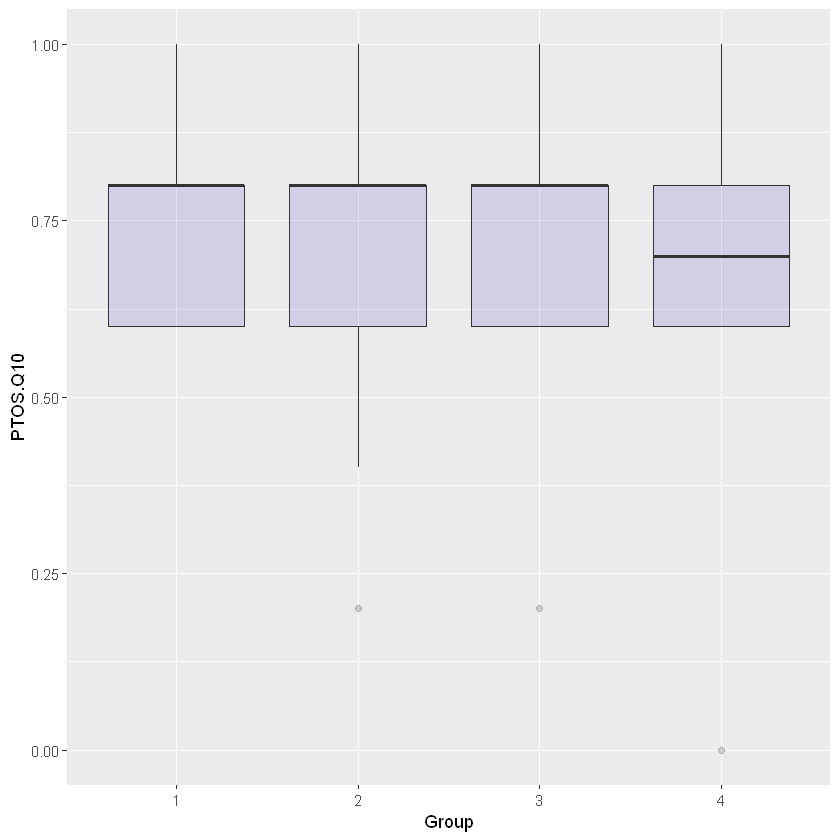

Group,Q10_mean,Q10_sd,Q11_mean,Q11_sd,n
1,0.7500000,0.1243163,0.5833333,0.4174236,12
2,0.6833333,0.2167249,0.6250000,0.4330127,12
3,0.7142857,0.2032700,0.5357143,0.4584374,14
4,0.6600000,0.2674987,0.2500000,0.4249183,10


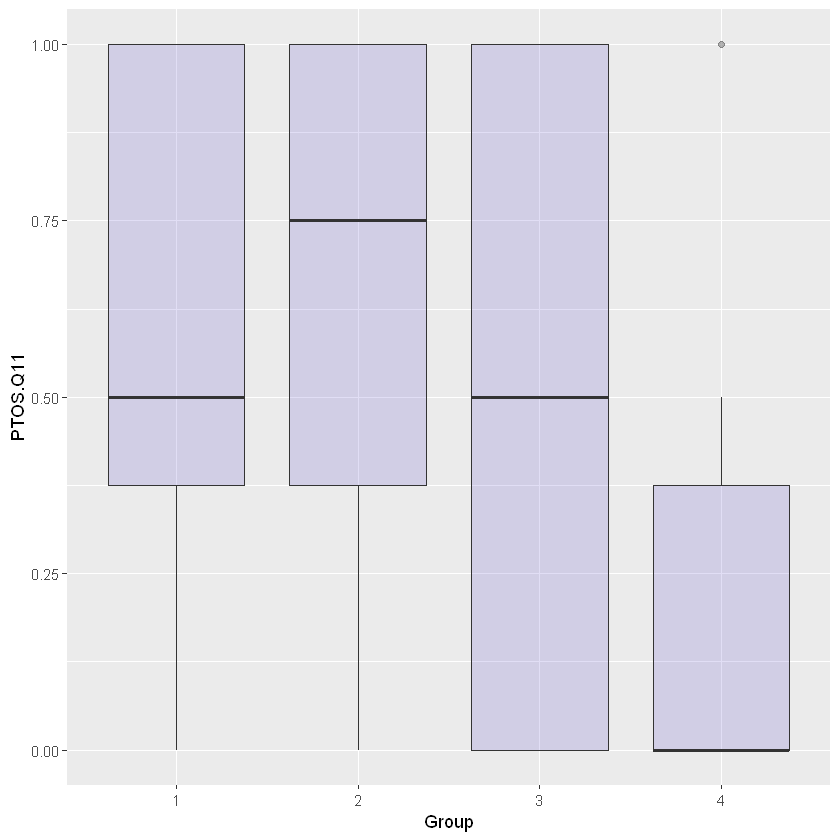

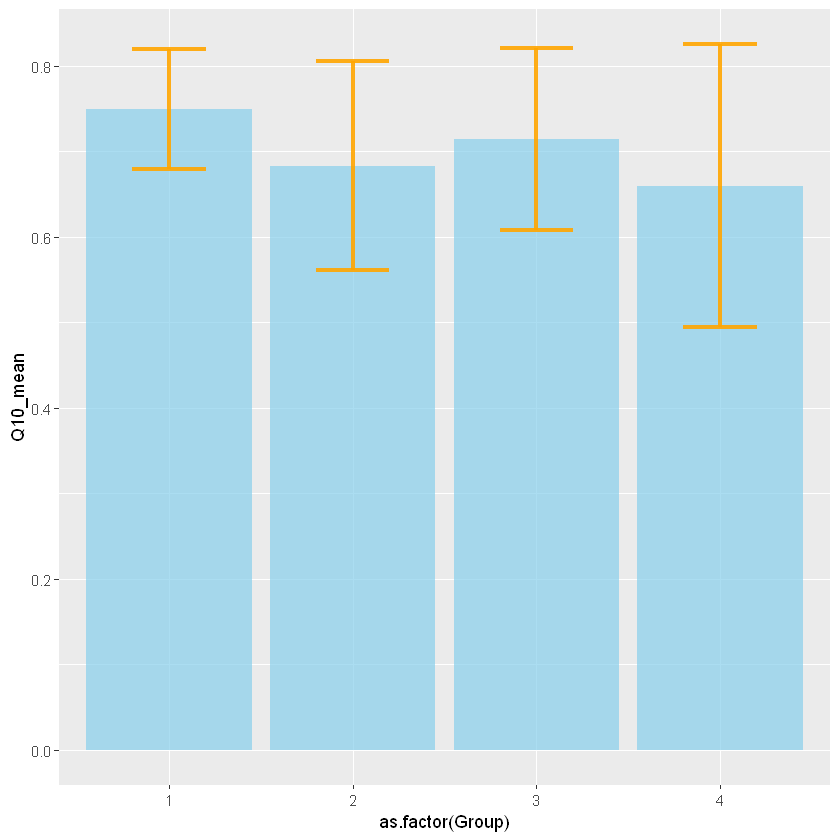

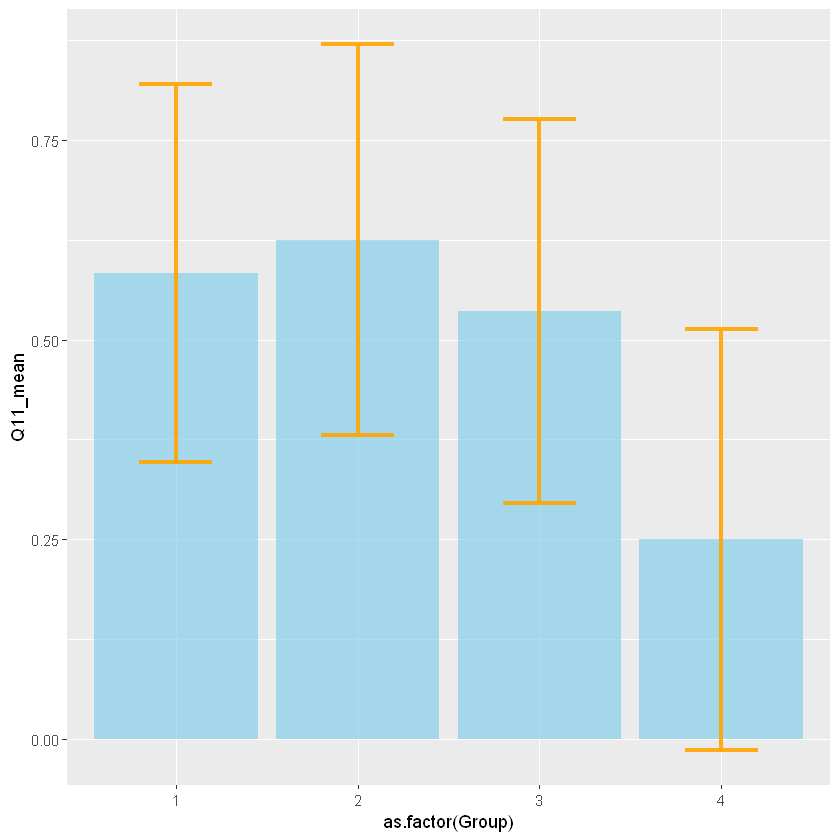

In [13]:
group_data <-read.csv2("dadosGrupos.csv", header = TRUE, sep = ";")
head(group_data)
group_data <-as.data.frame(group_data[c(2,3,4)])
group_data[c(1)] = lapply(group_data[c(1)], factor)
summary(group_data)

ggplot(group_data, aes(x=as.factor(GRUPO), y=PTOS.Q10)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Group")

ggplot(group_data, aes(x=as.factor(GRUPO), y=PTOS.Q11)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Group")

n <- count(group_data, var = GRUPO)
group_data <- group_data %>% group_by(GRUPO) %>% summarise(across(everything(), list(mean,sd)))
group_data$n <- n$n
colnames(group_data) <- c("Group", "Q10_mean", "Q10_sd", "Q11_mean", "Q11_sd", "n")
group_data


ggplot(group_data) +
geom_bar( aes(x=as.factor(Group), y=Q10_mean), stat="identity", fill="skyblue", alpha=0.7) +
    geom_errorbar( aes(x=as.factor(Group), ymin=Q10_mean-(1.96*Q10_sd/sqrt(n)), ymax=Q10_mean+(1.96*Q10_sd/sqrt(n))), width=0.4, colour="orange", alpha=0.9, size=1.3)

ggplot(group_data) +
geom_bar( aes(x=as.factor(Group), y=Q11_mean), stat="identity", fill="skyblue", alpha=0.7) +
    geom_errorbar( aes(x=as.factor(Group), ymin=Q11_mean-(1.96*Q11_sd/sqrt(n)), ymax=Q11_mean+(1.96*Q11_sd/sqrt(n))), width=0.4, colour="orange", alpha=0.9, size=1.3)


Group,TQ1,Q10_sd,TQ2,Q11_sd,n
1,0.7500000,0.1243163,0.5833333,0.4174236,12
2,0.6833333,0.2167249,0.6250000,0.4330127,12
3,0.7142857,0.2032700,0.5357143,0.4584374,14
4,0.6600000,0.2674987,0.2500000,0.4249183,10


Group,variable,value
1,TQ1,0.7500000
2,TQ1,0.6833333
3,TQ1,0.7142857
4,TQ1,0.6600000
1,TQ2,0.5833333
2,TQ2,0.6250000
3,TQ2,0.5357143
4,TQ2,0.2500000


Group,Question,value,sd,n
1,TQ1,0.7500000,0.1243163,12
2,TQ1,0.6833333,0.2167249,12
3,TQ1,0.7142857,0.2032700,14
4,TQ1,0.6600000,0.2674987,10
1,TQ2,0.5833333,0.4174236,12
2,TQ2,0.6250000,0.4330127,12
3,TQ2,0.5357143,0.4584374,14
4,TQ2,0.2500000,0.4249183,10


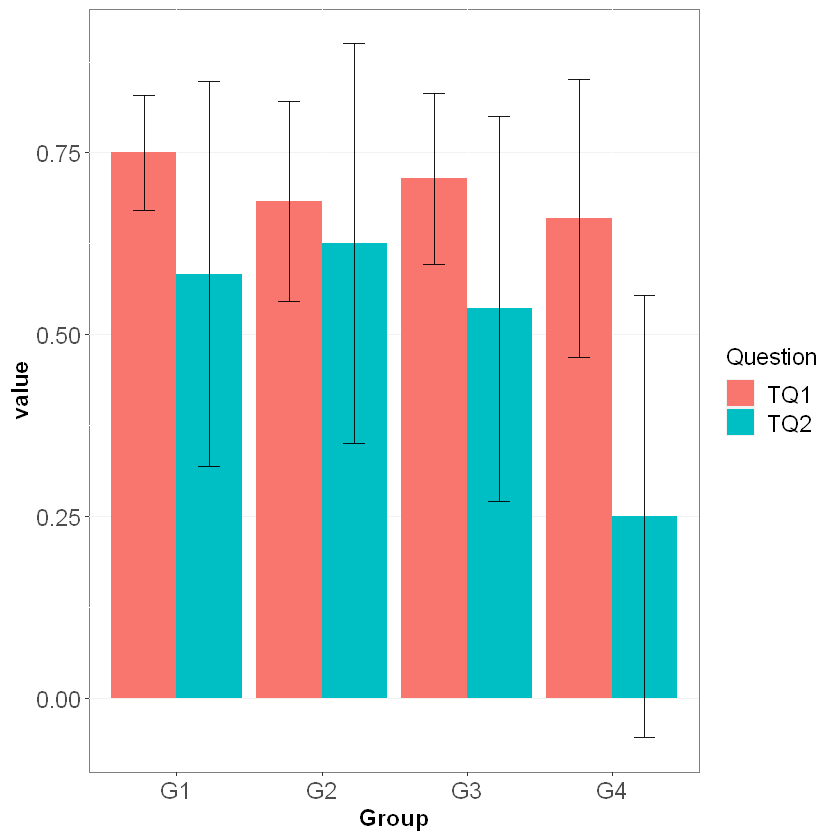

In [14]:
colnames(group_data) <- c("Group", "TQ1", "Q10_sd", "TQ2", "Q11_sd", "n")
group_data

#melt(as.data.frame(group_data), id.vars = "Group", measure.vars = c("Q10_mean", "Q11_mean"))
#group_data_melt <- melt(as.data.frame(group_data), id=c("Group"))
group_data_melt <- melt(as.data.frame(group_data[,c('Group', 'TQ1', 'TQ2')]), id.vars = c(1))
group_data_melt

group_data_melt$sd <- group_data$Q10_sd
group_data_melt[5:8,4] <- group_data$Q11_sd
group_data_melt$n <- group_data$n
colnames(group_data_melt)[2] <- "Question"
group_data_melt

#Calculando o intervalo de confianca
alpha=0.05
#t <- qt((1-alpha)/2 + .5, n-1)

ggplot(group_data_melt, aes(fill=Question, y=value, x=Group)) + 
    geom_bar(position="dodge", stat="identity") +
    scale_x_discrete(labels = c("G1", "G2", "G3", "G4")) +
    labs(color = "Question") +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          panel.grid.major.y = element_line(colour = "#f2f2f2"),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.title = element_text(size=14),
          legend.text = element_text(size=14)) +
    geom_errorbar( aes(ymin=value-(qt((1-alpha)/2 + .5, n-1)*sd/sqrt(n)), ymax=value+(qt((1-alpha)/2 + .5, n-1)*sd/sqrt(n))), width=0.3, position=position_dodge(.9), colour="black", alpha=0.9, size=0.5)
    

Group,TQ1,Q10_sd,TQ2,Q11_sd,n
G1,0.7500000,0.12431631,0.5833333,0.4174236,12
G2K2,0.2000000,0.00000000,0.5000000,0.0000000,1
G2K4,0.2800000,0.38987177,0.2000000,0.4472136,5
G3,0.7142857,0.20326997,0.5357143,0.4584374,14
G4K2,0.7428571,0.09759001,0.7142857,0.3933979,7
G4K4,0.7666667,0.19663842,0.1666667,0.2581989,6


Group,variable,value
G1,TQ1,0.7500000
G2K2,TQ1,0.2000000
G2K4,TQ1,0.2800000
G3,TQ1,0.7142857
G4K2,TQ1,0.7428571
G4K4,TQ1,0.7666667
G1,TQ2,0.5833333
G2K2,TQ2,0.5000000
G2K4,TQ2,0.2000000
G3,TQ2,0.5357143


Group,Question,value,sd,n
G1,TQ1,0.7500000,0.12431631,12
G2K2,TQ1,0.2000000,0.00000000,1
G2K4,TQ1,0.2800000,0.38987177,5
G3,TQ1,0.7142857,0.20326997,14
G4K2,TQ1,0.7428571,0.09759001,7
G4K4,TQ1,0.7666667,0.19663842,6
G1,TQ2,0.5833333,0.41742355,12
G2K2,TQ2,0.5000000,0.00000000,1
G2K4,TQ2,0.2000000,0.44721360,5
G3,TQ2,0.5357143,0.45843738,14


Warning message in qt((1 - alpha)/2 + 0.5, n - 1):
"NaNs produzidos"Warning message in qt((1 - alpha)/2 + 0.5, n - 1):
"NaNs produzidos"

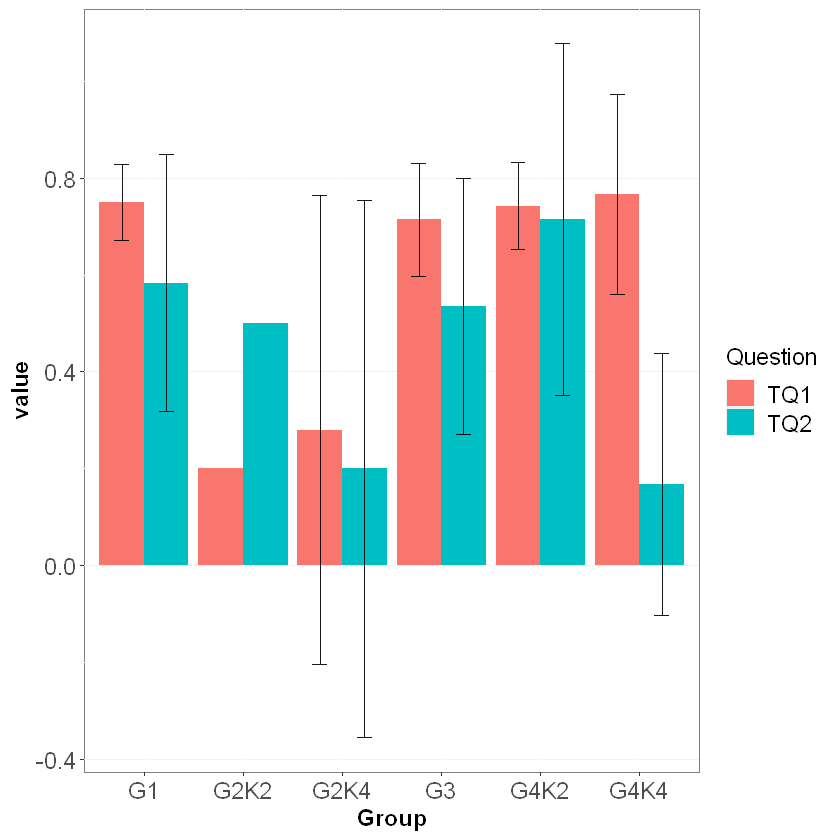

In [15]:
aval_groups <- data.frame(matrix(ncol = 6, nrow = 0))
names(aval_groups) <- c("Group", "TQ1", "Q10_sd", "TQ2", "Q11_sd", "n")

aval_groups[1,1] <- "G1"
aval_groups[1,2:6] <- group_data[1,2:6]
aval_groups[2,1] <- "G2K2"
aval_groups[2,2:6] <- aval_stats_grupos[3,3:7]
aval_groups[3,1] <- "G2K4"
aval_groups[3,2:6] <- aval_stats_grupos[4,3:7]
aval_groups[4,1] <- "G3"
aval_groups[4,2:6] <- group_data[3,2:6]
aval_groups[5,1] <- "G4K2"
aval_groups[5,2:6] <- aval_stats_grupos[7,3:7]
aval_groups[6,1] <- "G4K4"
aval_groups[6,2:6] <- aval_stats_grupos[8,3:7]
aval_groups[2,3] <- 0
aval_groups[2,5] <- 0


aval_groups

aval_groups_melt <- melt(as.data.frame(aval_groups[,c('Group', 'TQ1', 'TQ2')]), id.vars = c(1))
aval_groups_melt

aval_groups_melt$sd <- aval_groups$Q10_sd
aval_groups_melt[7:12,4] <- aval_groups$Q11_sd
aval_groups_melt$n <- aval_groups$n
colnames(aval_groups_melt)[2] <- "Question"
aval_groups_melt

ggplot(aval_groups_melt, aes(fill=Question, y=value, x=Group)) + 
    geom_bar(position="dodge", stat="identity") +
    #scale_x_discrete(labels = c("G1", "G2", "G3", "G4")) +
    labs(color = "Question") +
    theme(panel.background = element_rect(fill = "white", colour = "grey50"),
          panel.grid.major.y = element_line(colour = "#f2f2f2"),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.title = element_text(size=14),
          legend.text = element_text(size=14)) +
    geom_errorbar( aes(ymin=value-(qt((1-alpha)/2 + .5, n-1)*sd/sqrt(n)), ymax=value+(qt((1-alpha)/2 + .5, n-1)*sd/sqrt(n))), width=0.3, position=position_dodge(.9), colour="black", alpha=0.9, size=0.5)
    